In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import metrics, linear_model
from sklearn import model_selection
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE, RFECV, SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
import cmath

from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

%matplotlib inline
import random

file = "QSARData.csv"

df = pd.read_csv(file)

print("original shape:", df.shape)

# ## Check for missing data

def missing_data(data):
    missing_df = data.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['variable', 'missing values']
    missing_df['coverage (%)']=(data.shape[0]-missing_df['missing values'])/data.shape[0]*100
    missing_df.sort_values('coverage (%)').reset_index(drop = True)
    print(missing_df.loc[missing_df['coverage (%)'] < 90.0])
    less_cov = missing_df.loc[missing_df['coverage (%)'] < 90.0]
    return missing_df, less_cov


missing_df, low_cov_data = missing_data(df)
low_cols = list(low_cov_data['variable'])
df_high = df.drop(columns = low_cols, axis=1)
print("shape after dropping null columns: ", df_high.shape)

original shape: (179, 321)
          variable  missing values  coverage (%)
219  Wgamma1.unity             179           0.0
220  Wgamma2.unity             179           0.0
221  Wgamma3.unity             179           0.0
229       WG.unity             179           0.0
shape after dropping null columns:  (179, 317)


In [4]:
## Separate the dependent and independent variables 

original = df_high.copy()
y_var = original['depVar']
original.drop(columns = ['depVar','Unnamed: 0'], inplace = True, axis=1)

In [5]:
## Removed highly correlated predictors

print("original shape: ", original.shape)

# Create correlation matrix
corr_matrix = original.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print("number of features with correlations over 0.8: ", len(to_drop))

# Drop columns 
dropped = original.drop(columns = to_drop, axis=1)

print("updated shape:", dropped.shape)   

dropped.head(4)

original shape:  (179, 315)
number of features with correlations over 0.8:  173
updated shape: (179, 142)


,XLogP,MW,LipinskiFailures,nRotB,nAtomLAC,nAtomP,nBase,ALogP,nAcid,nSmallRings,...,WD.unity,BCUTw.1l,BCUTc.1l,BCUTc.1h,BCUTp.1l,PNSA.1,PNSA.3,RPCG,RPCS,RNCS
0,3.039,282.146724,0,0,0,3,0,0.8012,0,5,...,1.474806,11.999,-0.314393,0.267195,4.745096,124.877588,-26.548908,0.168942,0.185955,2.032461
1,5.687,386.209324,1,5,4,6,0,1.3625,0,6,...,1.307998,11.999,-0.314125,0.264376,4.471269,197.510368,-29.398959,0.132376,0.349696,0.963157
2,2.746,268.131074,0,0,0,3,0,0.5412,0,5,...,1.473248,11.999,-0.314390,0.264340,4.430722,135.776837,-30.360719,0.172827,0.586998,2.523145
3,3.039,282.146724,0,0,0,3,0,0.8012,0,5,...,1.474258,11.999,-0.314393,0.267195,4.745096,124.671077,-26.576362,0.168942,0.185955,2.032461


In [6]:
## Variance threshold feature selection

# Get feature variables that have zero variance for all samples

print("original shape: ", dropped.shape)
sel = VarianceThreshold(threshold=(0))
sel.fit_transform(dropped)

# Keep only columns that have a greater variance than 0.0 for all data samples 

dropped_sel = dropped[dropped.columns[sel.get_support(indices=True)]]
print("processed shape: ", dropped_sel.shape)
dropped_sel.head(4)
columns_from_dropped_sel = dropped_sel.columns
columns_from_dropped_sel_df = pd.DataFrame(columns_from_dropped_sel)

original shape:  (179, 142)
processed shape:  (179, 75)


Index(['XLogP', 'MW', 'LipinskiFailures', 'nRotB', 'nAtomLAC', 'nAtomP',
       'nBase', 'ALogP', 'nAcid', 'nSmallRings', 'nRings5', 'nRings7',
       'tpsaEfficiency', 'WTPT.3', 'WTPT.5', 'topoShape', 'geomShape',
       'MDEC.11', 'MDEC.12', 'MDEC.13', 'MDEC.24', 'MDEC.33', 'MDEC.34',
       'MDEC.44', 'MDEO.11', 'MDEO.12', 'MDEO.22', 'MDEN.22', 'MDEN.23',
       'khs.dCH2', 'khs.ssCH2', 'khs.dsCH', 'khs.dssC', 'khs.aaaC', 'khs.sNH2',
       'khs.ssNH', 'khs.dsN', 'khs.aaN', 'khs.sssN', 'khs.sOH', 'khs.dO',
       'khs.aaO', 'khs.sF', 'khs.dsssP', 'khs.dS', 'khs.aaS', 'khs.ddssS',
       'khs.sCl', 'khs.sBr', 'FMF', 'SC.3', 'SC.4', 'SC.6', 'SCH.6', 'C1SP2',
       'C1SP3', 'C4SP3', 'ATSc4', 'ATSc5', 'Wlambda1.unity', 'Wlambda2.unity',
       'Wnu1.unity', 'Weta1.unity', 'Weta2.unity', 'Weta3.unity', 'WD.unity',
       'BCUTw.1l', 'BCUTc.1l', 'BCUTc.1h', 'BCUTp.1l', 'PNSA.1', 'PNSA.3',
       'RPCG', 'RPCS', 'RNCS'],
      dtype='object')


/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


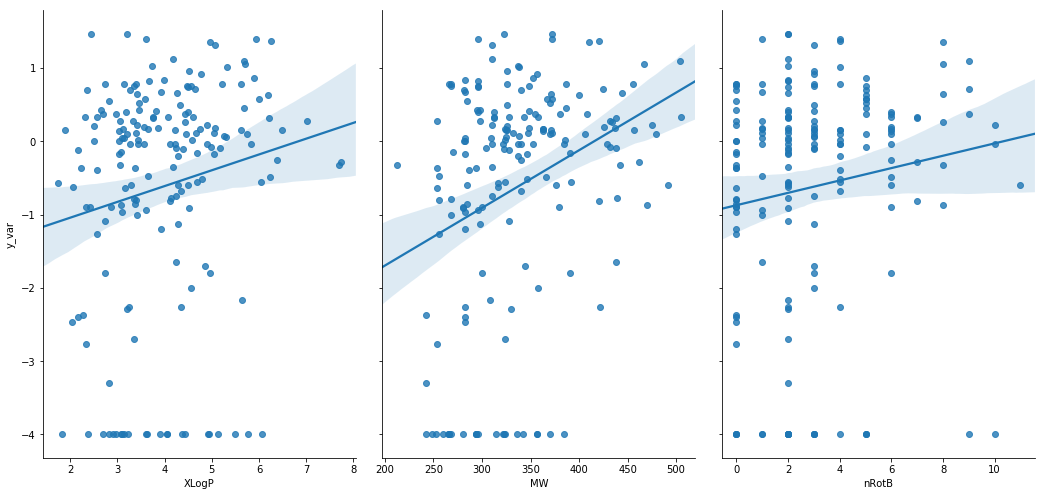

In [7]:
## Feature Analysis
print(dropped_sel.columns)

dropped_sel['y_var'] = y_var 
sns.pairplot(dropped_sel, x_vars=['XLogP','MW','nRotB'], y_vars='y_var', size=7, aspect=0.7, kind='reg')
plt.show()


In [10]:
# Feature set should include all columns except for the label y 
dropped_sel.drop(columns=['y_var'], axis=1, inplace=True)
y_arr = np.array(y_var)
y = y_arr.reshape(-1,1)
X = np.array(dropped_sel)

## Train and test set split 
X_train, X_test, y_train, y_test = train_test_split(X, y_arr, test_size=0.2, random_state=0)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test", y_test.shape)


X_train:  (143, 75)
X_test:  (36, 75)
y_train:  (143,)
y_test (36,)


/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Average MSE for linear regression model: 8.008 (+/- 4.793)
Average R2 for linear regression model: -2.385 (+/- 1.944)


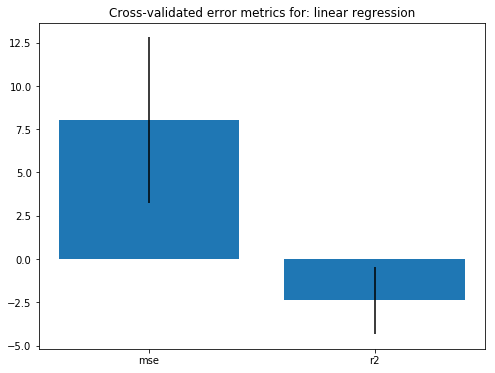

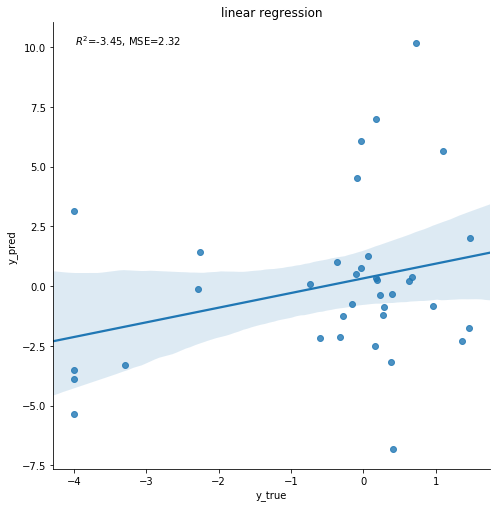

/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


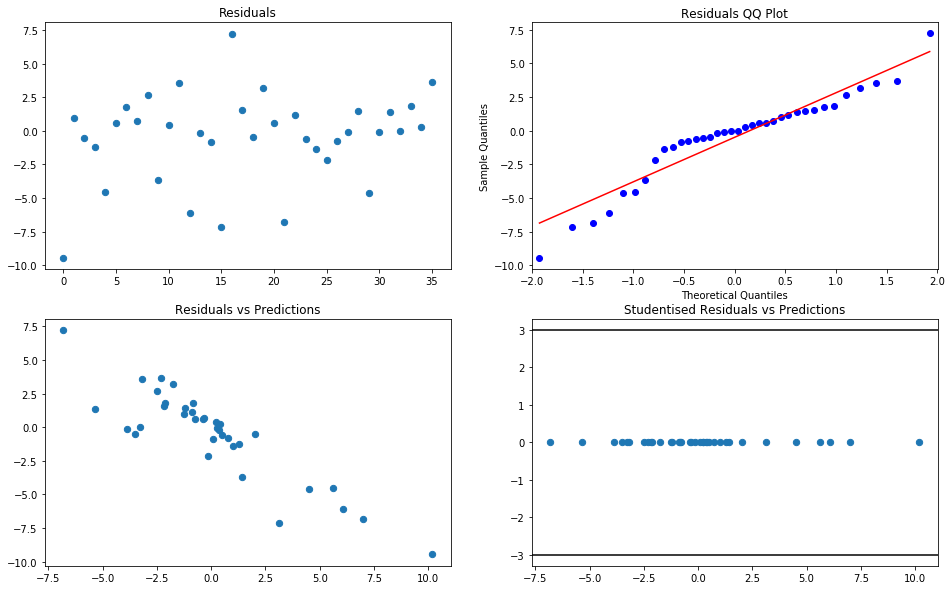

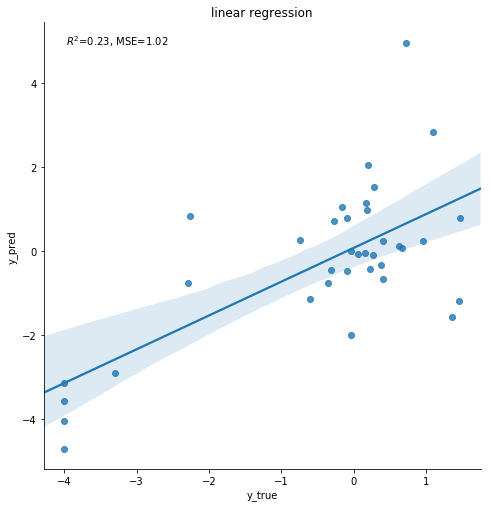

/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


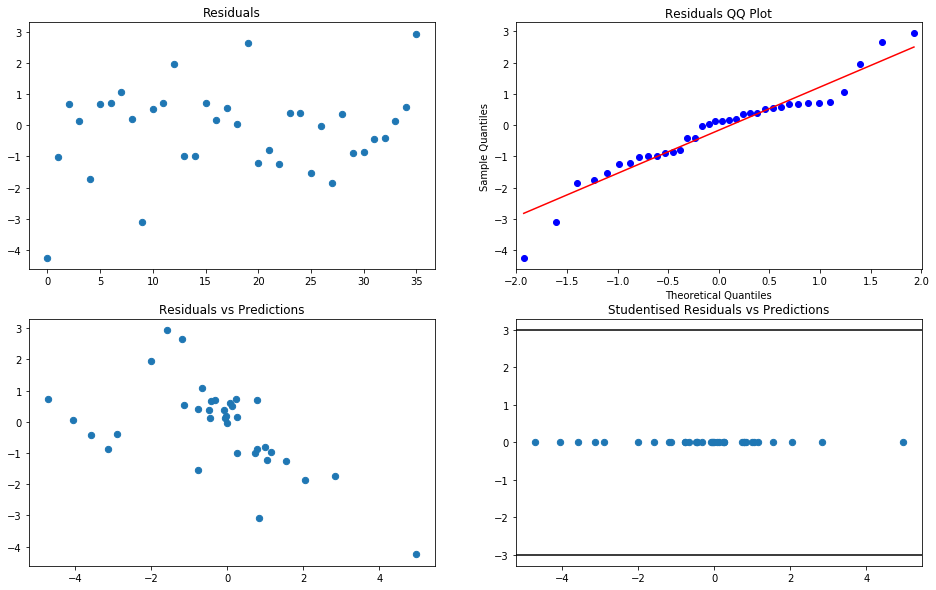

best model: 1 r2 score: 0.23


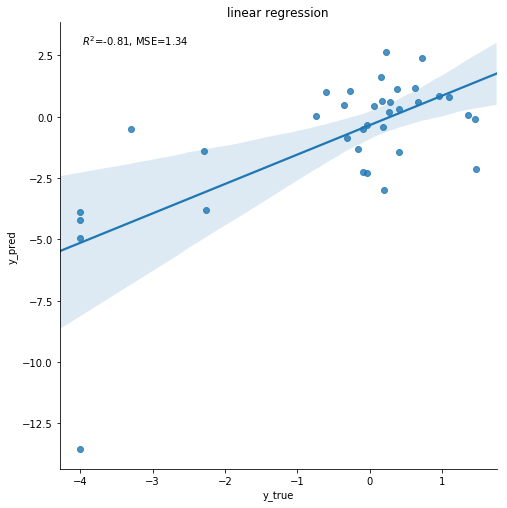

/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


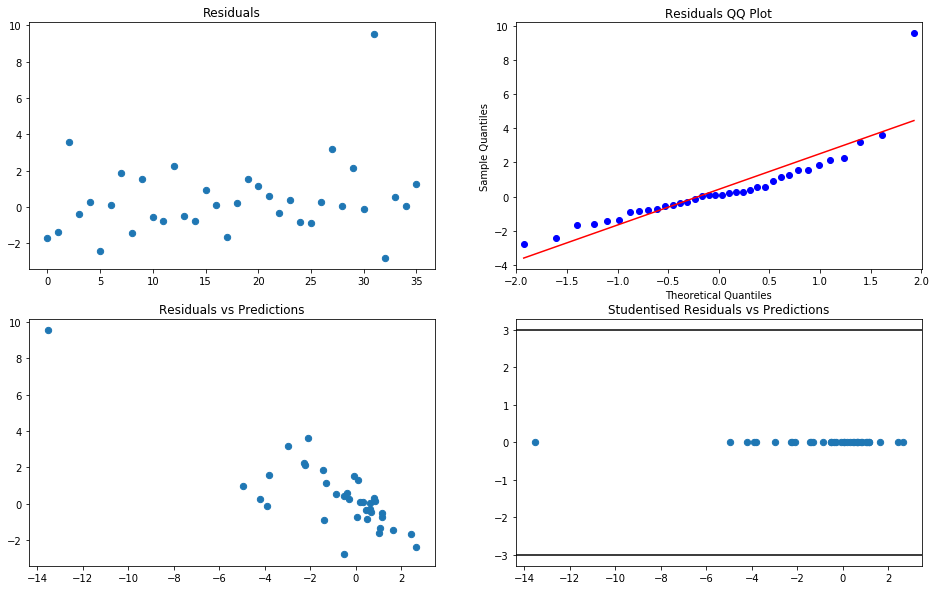

Average MSE for random forest regression model: 1.013 (+/- 0.257)
Average R2 for random forest regression model: 0.584 (+/- 0.073)


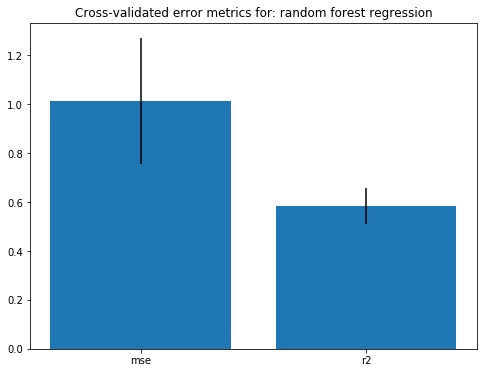

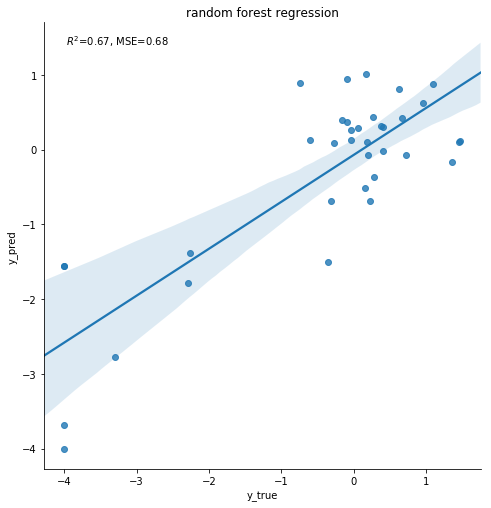

best model: 0 r2 score: 0.67


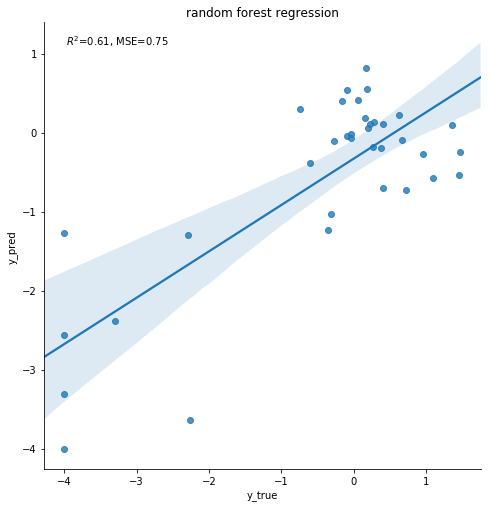

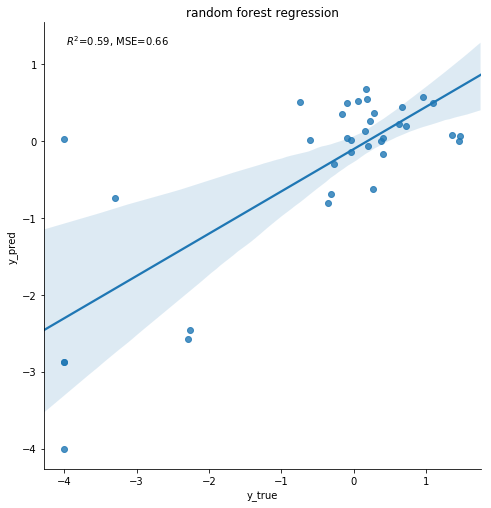

In [11]:
## Preprocessing 

# Normalisations scaling
scaler = preprocessing.StandardScaler()

## Linear model testing with cross-validation 
linear = linear_model.LinearRegression()
rf = RandomForestRegressor()

metric = ['neg_mean_squared_error', 'r2']

def fit_model(X, y, model, model_name):
    clf = make_pipeline(scaler, model)
    scores = cross_validate(model, X, y, cv=3, scoring=metric, return_train_score=False, return_estimator=True)
    preds = cross_val_predict(model, X, y, cv=3)
    train = pd.DataFrame(preds)
    train.columns = ['y_pred']
    train['y_true'] = y
    print("Average MSE for %s model: %0.3f (+/- %0.3f)" % (model_name, -1 * scores['test_neg_mean_squared_error'].mean(), scores['test_neg_mean_squared_error'].std()))
    print("Average R2 for %s model: %0.3f (+/- %0.3f)" % (model_name, scores['test_r2'].mean(),scores['test_r2'].std()))
    means = []
    stds = []
    names = ['mse', 'r2']
    means.append(-1 * scores['test_neg_mean_squared_error'].mean())
    means.append(scores['test_r2'].mean())
    stds.append(-1 * scores['test_neg_mean_squared_error'].std())
    stds.append(scores['test_r2'].std())
    ## Error metric plots
    plt.figure(figsize=(8,6))
    plt.title("Cross-validated error metrics for: " + model_name)
    plt.bar(names, means, yerr=stds)
    plt.show()
    return scores

def plot_residuals(X_train, y_test, pred):
    residuals = y_test - pred
    res_df = pd.DataFrame(residuals)
    res_df.columns = ['residuals']
    res_squared = residuals ** 2
    rss = sum(res_squared)
    n = len(residuals)
    p = X_train.shape[1]
   # denom = 
    #print(rss, n, p, denom)
    rse = cmath.sqrt((rss/(n-p-1.0)))

    # studentised residuals
    res_df['studentised_residuals'] = res_df['residuals'] / rse

    fig, ax = plt.subplots(2,2, figsize=(16,10))
    ax[0,0].scatter(x=res_df.index.values, y=res_df['residuals'], s=40)
    ax[0,0].set_title("Residuals")
    sm.qqplot(residuals, line='s', ax=ax[0,1])
    ax[0,1].set_title("Residuals QQ Plot")
    ax[1,0].scatter(pred, res_df['residuals'], s=40)
    ax[1,0].set_title("Residuals vs Predictions")
    ax[1,1].scatter(pred,res_df['studentised_residuals'], s=40)
    ax[1,1].set_title("Studentised Residuals vs Predictions")
    ax[1,1].axhline(y=3, c='black')
    ax[1,1].axhline(y=-3, c='black')
    plt.show()
    
def evaluate_models(scores, X_test, y_test, name, return_best_estimator=True):
    best_r2 = 0
    best_mae = 0
    #y_test.reset_index(inplace=True)
    for i in range(len(scores['estimator'])):
        model = scores['estimator'][i]
        pred = model.predict(X_test)
        test = pd.DataFrame(pred)
        test.columns = ['y_pred']
        test['y_true'] = y_test
        sns.pairplot(test, x_vars='y_true', y_vars='y_pred', height=7, aspect=1, kind='reg')
        plt.title(name)
        plt.annotate('$R^2$=%.2f, MSE=%.2f' % (metrics.r2_score(y_test, pred), metrics.mean_absolute_error(y_test, pred)), xy=(0.05, 0.95), xycoords='axes fraction')
        plt.show()
        if name == 'linear regression':
            plot_residuals(X_test, y_test, pred)
        if metrics.r2_score(y_test, pred) > best_r2:
            best_r2  = metrics.r2_score(y_test, pred)
            best_model = model
            print("best model: %s r2 score: %0.2f" % (i, best_r2))
    return best_model

lin_scores = fit_model(X_train, y_train, linear, 'linear regression')
lin_best = evaluate_models(lin_scores, X_test, y_test, 'linear regression')

rf_scores = fit_model(X_train, y_train, rf, 'random forest regression')
rf_best = evaluate_models(rf_scores, X_test, y_test, 'random forest regression')


## Random Forest Model Analysis

ranked: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


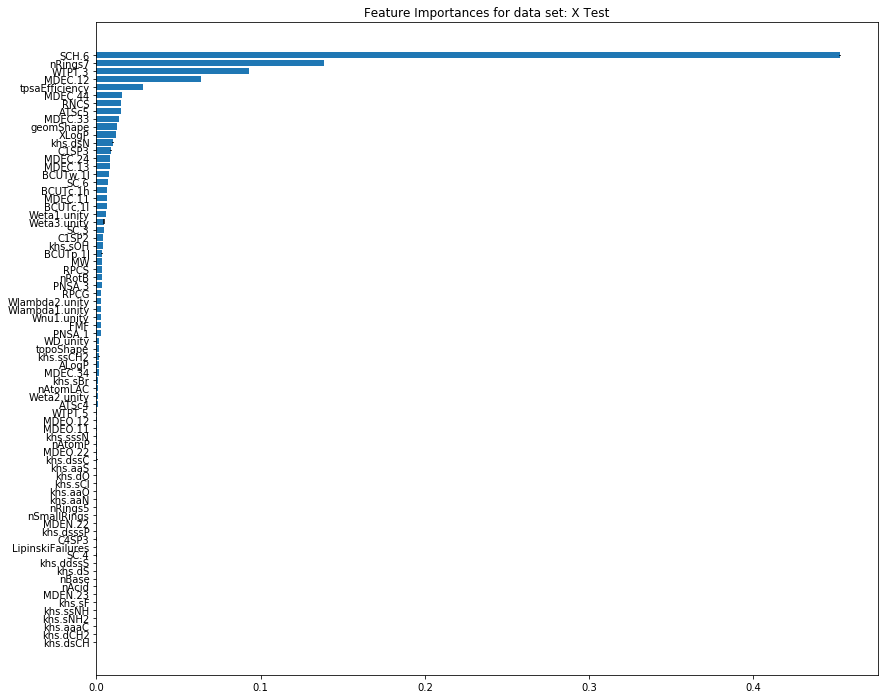

In [25]:
## Feature importance 

def rf_feature_importance(data, model, X, name):
    n_col = data.shape[1]
    features = data.columns[0:n_col]
    pred = model.predict(X)
    #m=RandomForestRegressor(n_estimators=50, oob_score=True,n_jobs=-1,bootstrap=True,random_state=42)
    rank = model.feature_importances_
    indices = np.argsort(model.feature_importances_)
    #top = rank[indices][:20]
    std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
    plt.figure(figsize=(14,12))
    plt.barh(range(len(indices)), rank[indices], align='center', yerr=std)
    plt.yticks(range(len(indices)), features[indices])
    plt.title('Feature Importances for data set: %s' % name)
    return rank, indices
    
dropped_sel_df = pd.DataFrame(dropped_sel)
rank, indices = rf_feature_importance(dropped_sel_df, rf_best, X_test, "X Test")
#print("ranked: %s" % (rank[indices][:10]))


In [21]:
rank[indices]
n_col = dropped_sel_df.shape[1]
features = dropped_sel_df.columns[0:n_col]
features[indices]

Index(['khs.dO', 'nAtomP', 'C1SP2', 'khs.dssC', 'nRotB', 'nSmallRings',
       'MDEO.12', 'nAtomLAC', 'khs.ssCH2', 'C1SP3', 'MW', 'MDEC.34', 'SC.3',
       'MDEC.13', 'PNSA.1', 'BCUTp.1l', 'RPCS', 'PNSA.3', 'WTPT.5', 'MDEC.33',
       'Wlambda2.unity', 'Wlambda1.unity', 'RNCS', 'MDEC.11', 'XLogP', 'ALogP',
       'MDEC.24', 'MDEC.12', 'nRings7', 'WTPT.3', 'MDEO.22'],
      dtype='object')